In [2]:
from defaultPlots import scatter
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy 
import requests
from xgboost import XGBRegressor

In [3]:
# Request data file
url = 'https://rammb-data.cira.colostate.edu/ships/data/AL/lsdiaga_1982_2022_sat_ts_5day.txt'
response = requests.get(url)
# Check if the request was successful
if response.status_code == 200:
    lines = response.text.strip().splitlines()
    del response  # Free memory
else:
    raise RuntimeError(f"Failed to retrieve data. Status code: {response.status_code}")
data_list = [line.strip().split() for line in lines]
del lines  # Free memory

In [18]:
# Initialize temporary lists
storm_id = []
locs = []
sst = []
sst24 = []
rhmid = []
RIFlag = []
windStart = []
windEnd = []
deepmag = []
deepdir = []
mpi = []
lats = []
lons = []
names = []
div = []
shear_tend = []
dist = []
dist_12 = []
dist_24 = []
rhtend = []
delwind = []
t200 = []
ohc = []
tadv = []
uMotion = []
vMotion = []
motion = []
convectionArea = []
lat24 = []
for i, val in enumerate(data_list):
    if val[-1] == 'HEAD':
        try:
            year = int(val[-2][4:8])
            if year < 2000:
                continue
            # print(year)
            
            storm_name = val[0]
            storm_code = val[7][4:] + val[1][2:] + val[2]
            winds = int(val[3])
            windE = int(data_list[i + 2][6])
            windP = int(data_list[i + 2][0])
            if windP < -1000:
                windP = np.nan
            if (windE - winds) >= 30:
                temp = True
            else:
                temp = False
            lat = float(val[4])
            lon = float(val[5])

            storm_id.append((storm_name, storm_code, winds, lat, lon))
            locs.append(i)
            delwind.append(winds - windP)
            windStart.append(winds)
            windEnd.append(windE)
            dist.append(float(data_list[i+14][2]))
            dist_12.append(float(data_list[i+14][4]))
            dist_24.append(float(data_list[i+14][6]))
            sst.append(int(data_list[i+18][2]) / 10)
            sst24.append(int(data_list[i+18][6]) / 10)
            rhmid.append((float(data_list[i+28][0])))
            rhtend.append((float(data_list[i+28][4])))
            deepmag.append(float(data_list[i+60][0]) / 10)
            deepdir.append(float(data_list[i+61][0]))
            shear_tend.append(float(data_list[i+60][4]) / 10)
            mpi.append(float(data_list[i+66][0]))
            t200.append(float(data_list[i+58][0]))
            lats.append(lat)
            lons.append(lon)
            div.append(float(data_list[i+33][0]))
            ohc.append(float(data_list[i+100][0]))
            tadv.append(float(data_list[i+51][0]))
            uMotion.append(float(data_list[i+31][1]) / 10)
            vMotion.append(float(data_list[i+31][2]) / 10)
            convectionArea.append(float(data_list[i+132][7]))
            lat24.append(float(data_list[i + 8][6]))
            locs.append(i)
            names.append(storm_name)
        except Exception:
            continue
motion = (np.array(uMotion)**2 + np.array(vMotion)**2)**0.5

In [5]:
def norm(data):
    return (np.nanmax(data) - data) / (np.nanmax(data) - np.nanmin(data))

In [6]:
def regression(input, output, RF = True, GB = False): 
    print(input.shape, output.shape)    
    trainIn = input[:5500]
    trainOut = output[:5500]
    testIn = input[5500:]
    testOut = output[5500:]

    if RF == True:
        regr = RandomForestRegressor(n_estimators=200, n_jobs=-1)#, max_features = 0.75, max_depth = 25)
        regr.fit(trainIn, trainOut) 
        predictTest = regr.predict(testIn)
    elif GB == True:
        regr = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)

    try:
        importance = regr.feature_importances_
    except:
        coef = np.abs(regr.coef_ * np.nanstd(input, axis = 0))
        importance = coef / np.sum(coef)

    corr, sig = scipy.stats.pearsonr(predictTest, testOut)
    error2 = np.sqrt(np.mean((predictTest - testOut)**2))
    error = np.mean(np.abs(predictTest - testOut))
    scatter(['Predicted DVMax (kt)', predictTest], ['DVMax (kt)', testOut])#, hline = False, vline = False)

    print(str(error) + f"kt MAE\n{str(error2)}kt RSME\nR^2: {corr**2}")

    # import pickle
    # with open(r"C:\Users\deela\Downloads\SHIPS_RF_RI.cpickle", 'wb') as f:
    #     pickle.dump(regr, f)

    return regr, predictTest, importance, testIn, testOut

C:\Users\deela\AppData\Local\Temp\ipykernel_30952\118236764.py:2: RuntimeWarning: divide by zero encountered in divide
  x = [sst, np.array(sst) / np.array(ohc), windStart, rhmid, deepmag, deepdir, np.array(windStart) - np.array(mpi), np.sin(np.deg2rad(lats)), np.cos(np.deg2rad(lats)), rhtend, delwind, shear_tend, dist_12, dist_24, div, t200, ohc, tadv, convectionArea, np.array(deepmag) * (np.array(sst)), np.array(convectionArea) * np.array(deepmag), (np.array(sst) - np.array(t200)) / np.array(mpi), ((100 - np.array(rhmid)) * np.array(deepmag)) / np.array(mpi)]


0 Sea Surface Temperature 8627
1 SST / OHC 8627
2 VMax 8627
3 Mid-Level RH 8627
4 Deep-Layer Shear (mag) 8627
5 Deep-Layer Shear (dir) 8627
6 VMax - MPI 8627
7 sin(lat) 8627
8 cos(lat) 8627
9 RH_TEND 8627
10 delwind_12 8627
11 shear_tend 8627
12 dist_12 8627
13 dist_24 8627
14 div 8627
15 t200 8627
16 OHC 8627
17 TADV 8627
18 Convection Area 8627
19 Shear * SST 8627
20 Convection Area * Shear 8627
21 (SST - T200) / MPI 8627
22 Vent Proxy 8627
(6402, 23) (6402,)
902 (902,)
[[1.0435415]]
-83.15 46.6


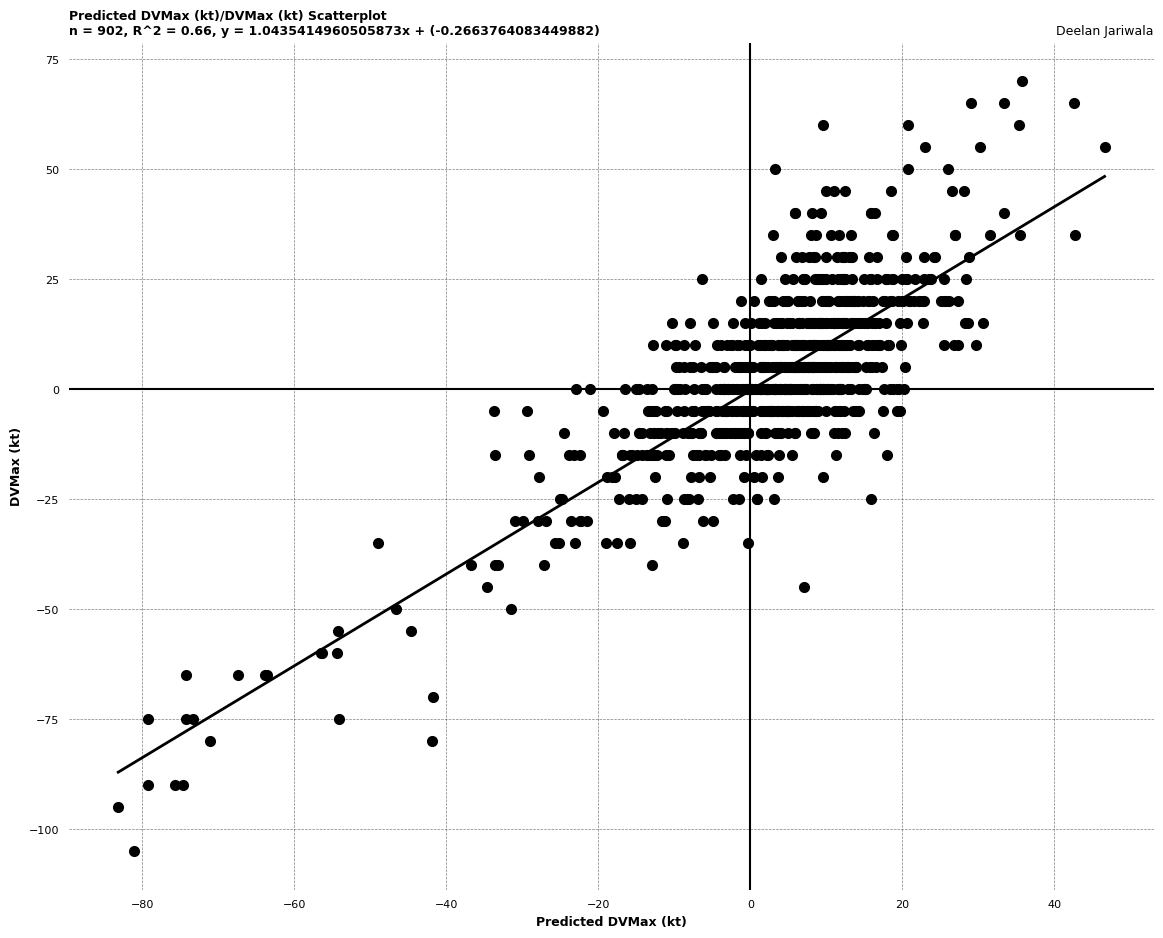

8.927937915742794kt MAE
11.857167436747272kt RSME
R^2: 0.6600002431599581
Feature:             Sea Surface Temperature, Importance: 0.021524905021595323
Feature:                           SST / OHC, Importance: 0.023621913063653844
Feature:                                VMax, Importance: 0.12269720367346731
Feature:                        Mid-Level RH, Importance: 0.017861906681941743
Feature:              Deep-Layer Shear (mag), Importance: 0.012636005871062716
Feature:              Deep-Layer Shear (dir), Importance: 0.026523076491171346
Feature:                          VMax - MPI, Importance: 0.13307873787191163
Feature:                            sin(lat), Importance: 0.023209649464973163
Feature:                            cos(lat), Importance: 0.023274304526258716
Feature:                             RH_TEND, Importance: 0.02198313413980721
Feature:                          delwind_12, Importance: 0.04062446493732718
Feature:                          shear_tend, Importance: 0.0

In [20]:
xNames = ['Sea Surface Temperature', 'SST / OHC', 'VMax', 'Mid-Level RH', 'Deep-Layer Shear (mag)', 'Deep-Layer Shear (dir)', 'VMax - MPI', 'sin(lat)', 'cos(lat)', 'RH_TEND', 'delwind_12', 'shear_tend', 'dist_12', 'dist_24', 'div', 't200', 'OHC', 'TADV', 'Convection Area', 'Shear * SST', 'Convection Area * Shear', '(SST - T200) / MPI', 'Vent Proxy']
x = [sst, np.array(sst) / np.array(ohc), windStart, rhmid, deepmag, deepdir, np.array(windStart) - np.array(mpi), np.sin(np.deg2rad(lats)), np.cos(np.deg2rad(lats)), rhtend, delwind, shear_tend, dist_12, dist_24, div, t200, ohc, tadv, convectionArea, np.array(deepmag) * (np.array(sst)), np.array(convectionArea) * np.array(deepmag), (np.array(sst) - np.array(t200)) / np.array(mpi), ((100 - np.array(rhmid)) * np.array(deepmag)) / np.array(mpi)]
y = np.array(windEnd) - np.array(windStart)

for i, (name, arr) in enumerate(zip(xNames, x)):
    print(i, name, len(arr))

x = [np.asarray(a, dtype=float) for a in x]
x = [np.where(a == 9999, np.nan, a) for a in x] 

y = np.where(y == 9999, np.nan, y)

# Start with a mask of all True
mask = ~np.isnan(y) & ~np.isinf(y)

# Update the mask based on each predictor
for i in range(len(x)):
    mask = mask & ~np.isnan(x[i]) & ~np.isinf(x[i])

# Apply the final mask to each predictor
for i in range(len(x)):
    x[i] = x[i][mask]
    # x[i] = norm(x[i])

# Apply the mask to the target
y = y[mask]

# Stack predictors into 2D array and regress
x = np.column_stack(x)

regr, predictTest, importance, testIn, testOut = regression(x, y, RF = True, GB = False)

feat = dict(zip(xNames, importance))
# Print one key-value pair at a time
for key, value in feat.items():
    print(f"Feature: {key:>35}, Importance: {value}")
print('\n')
# for x in range(len(storm_name)):
#     print(storm_name[x], y[x], predictTest[x])

In [8]:
# from sklearn.feature_selection import RFECV

# rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
# selector = RFECV(rf, step=1, scoring="neg_mean_absolute_error", n_jobs=-1, cv=5)
# selector.fit(x, y)
# print(selector.support_)     # True = kept, False = dropped
# print(selector.ranking_)     # Rank of each feature

In [9]:
# newNames = np.array(xNames)[selector.support_]
# newX = x[:, selector.support_]

# regr, predictTest, importance, testIn, testOut = regression(newX, y, RF = True, GB = False)

# feat = dict(zip(newNames, importance))
# # Print one key-value pair at a time
# for key, value in feat.items():
#     print(f"Feature: {key:>35}, Importance: {value}")
# print('\n')

In [10]:
# import shap

# explainer = shap.TreeExplainer(regr)
# shap_values = explainer.shap_values(testIn)

In [11]:
from matplotlib import patheffects 
import matplotlib.pyplot as plt  # Plotting library
import satcmaps as cmaps 

def plot(stime, SST, VMax, RH, DSHR, DDIR, MPI, LAT, SLAT, CLAT, RH24, VMAXd12, SHR24, DIST12, DIST24, DIV, T200, OHC, TADV, convectionArea):
       feature = np.array([SST, VMax, RH, DSHR, DDIR, VMax - MPI, SLAT, CLAT, RH24, VMAXd12, SHR24, DIST12, DIST24, DIV, T200, OHC, TADV, convectionArea])
       feat = np.array(feature).reshape(1, -1)
       fig = plt.figure(figsize=(14, 7))

       # Add the map and set the extent
       ax = plt.axes()
       ax.set_frame_on(False)
       ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
       ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
       ax.set_ylabel('Density', weight = 'bold', size = 9)
       ax.set_xlabel(f'Prediction (kt)', weight = 'bold', size = 9)
       ax.set_ylim(0, 0.05)

       predArray = np.array([tree.predict(feat) for tree in regr.estimators_]) + VMax# Shape: (n_trees, test)
       predSTD = np.nanstd(predArray, axis = 0)[0] 
       pred = regr.predict(feat)[0] + VMax

       # print(np.sum(predArray - VMax >= 30))
       count = int((np.sum(predArray - VMax >= 30) / len(predArray)) * 100)

       text = f"\nVMax:             {VMax} kt\n" \
              f"ML RH:                {RH}%\n" \
              f"MPI:                {MPI} kt\n" \
              f"LAT:                 {LAT}N\n" \
              f"SST:                  {SST}C" 
       ax.text(-7.5, 0.0035, text, bbox={'facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.75})
       ax.text(-7.5, 0.002, f"-------------------------------", bbox={'facecolor': 'None', 'edgecolor': 'None', 'alpha': 0.75})
       ax.text(-7.5, 0.0004, f"Prediction:   {round(pred, 1)} kt", color = 'red', bbox={'facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.75})


       u, v = -DSHR * np.sin(DDIR), -DSHR * np.cos(DDIR)

       ax.text(2.5, 0.0485, f'200-850mb', color = 'black', fontsize = 8, ha = 'center', fontweight = 'bold', path_effects = [patheffects.withStroke(linewidth=1.25, foreground="white")], zorder = 20, bbox={'facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.75})
       ax.quiver(2.5, 0.046, np.array([u]) / DSHR, np.array([v]) / DSHR, pivot = 'middle', scale = 30, minshaft = 3, minlength=0, headaxislength = 3, headlength = 3, color = '#ff5959', zorder = 20, path_effects = [patheffects.withStroke(linewidth=1.25, foreground="black")])
       ax.text(2.5, 0.0425, f'{round(DSHR, 1)} knots', fontsize = 8, color = 'black', ha = 'center', path_effects = [patheffects.withStroke(linewidth=1.25, foreground="white")], zorder = 20, bbox={'facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.75})

       plt.title(f'SHIPS-Based Random Forest 24hr Intensity Prediction\nNumber of Predictions: {len(predArray)}' , fontweight='bold', fontsize=8 + 1, loc='left')
       plt.title(f'Forecast Time: {stime}', fontsize=8 + 1, loc='center')
       plt.title(f'RI Probability: {count}%\nDeelan Jariwala & Zach Nice', fontsize=8 + 1, loc='right')  
       plt.hist(predArray, bins = np.arange(0, 160, 5), color = '#9f80ff', alpha = 0.5, density = True)
       plt.axvspan(pred - predSTD, pred + predSTD, color = 'red', alpha = 0.25, zorder = 0)
       plt.axvline(pred, color = 'red', label = f'Prediction: {round(pred, 1)}kt')
       length = pred - VMax
       
       if length > 0:
              length = length - 2
       else:
              length = length + 2
       ax.text((VMax + pred) / 2, 0.026, f'{round(pred - VMax, 1)} kt', fontsize = 8, color = 'black', ha = 'center', path_effects = [patheffects.withStroke(linewidth=1.25, foreground="white")], zorder = 20)#, bbox={'facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.25})
       ax.quiver((VMax + pred) / 2, 0.025, length, 0, pivot = 'middle', scale = 1, scale_units = 'xy', minshaft = 4, minlength=0, headaxislength = 3, headlength = 3, color = '#000000', zorder = 20, path_effects = [patheffects.withStroke(linewidth=1.25, foreground="black")])
       plt.axvline(VMax, color = 'black', label = f'Current Intensity: {round(VMax, 1)}kt')
       # plt.savefig(r"C:\Users\deela\Downloads\vmaxerrorhistogram.png", dpi = 400, bbox_inches = 'tight')
       plt.legend(loc = 'upper right')
       plt.show()

       # shapPlot(feature)

In [12]:
# def shapPlot(feature):
#     feat = feature[np.newaxis, :]
#     shapValues = explainer.shap_values(feat)[0]

#     explanation = shap.Explanation(values=shapValues, base_values=explainer.expected_value, data=feature, feature_names=xNames)

#     shap.plots.waterfall(explanation, show=False)
#     plt.title("Feature Importance (SHAP)")
#     plt.tight_layout()
#     plt.show()

08/18/2025 at 18z
12 Hour Trend: 5.0kt


ValueError: X has 18 features, but DecisionTreeRegressor is expecting 24 features as input.

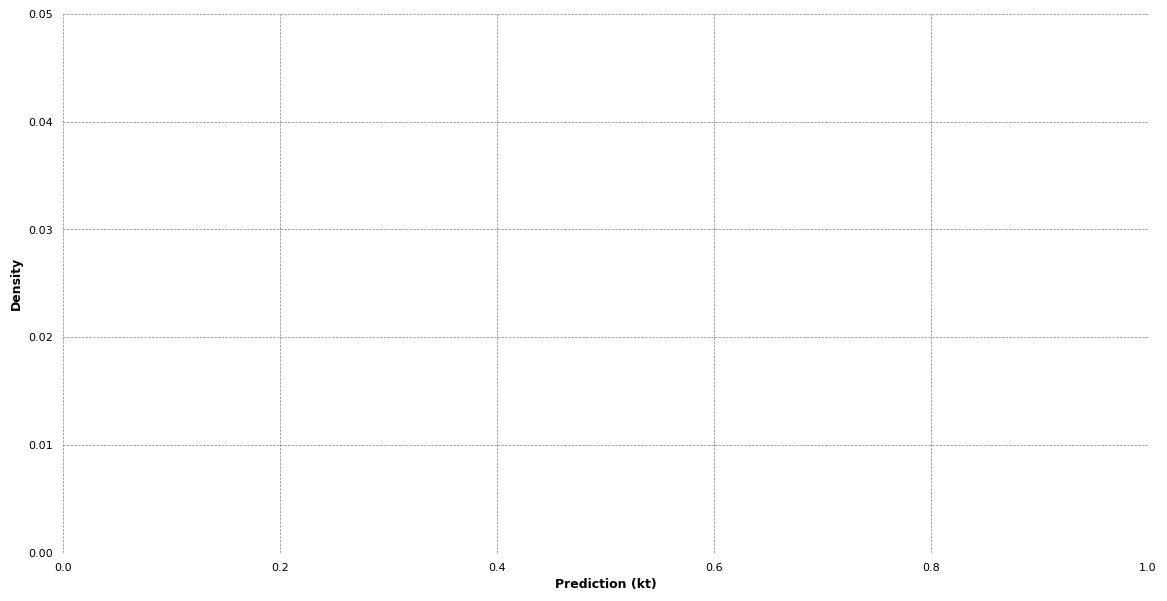

In [13]:
import SHIPSRetrieve as ships

line, stime, ri, an, link, VMAXd12, convectionArea = ships.ships('AL05', '25', '08', '18')

SST = float(line[6, 1])
VMax = float(line[1, 1])
RH = float(line[11, 1])
DSHR = float(line[3, 1])
DDIR = float(line[5, 1])
MPI = float(line[7, 1])
lat = float(line[17, 1])
SLAT, CLAT = np.sin(np.deg2rad(lat)), np.cos(np.deg2rad(lat))
RH24 = float(line[11, 5])
SHR24 = float(line[3, 5])
DIST12 = float(line[16, 3])
DIST24 = float(line[16, 5])
DIV = float(line[14, 1])
T200 = float(line[8, 1])
TADV = float(line[15, 1])
OHC = float(line[20, 1])
VMAXd12 = VMax - VMAXd12
print(f'12 Hour Trend: {VMAXd12}kt')

plot(stime, SST, VMax, RH, DSHR, DDIR, MPI, lat, SLAT, CLAT, RH24, VMAXd12, SHR24, DIST12, DIST24, DIV, T200, OHC, TADV, convectionArea)

902 (902,)
[[1.09662182]]
-53.05 50.825


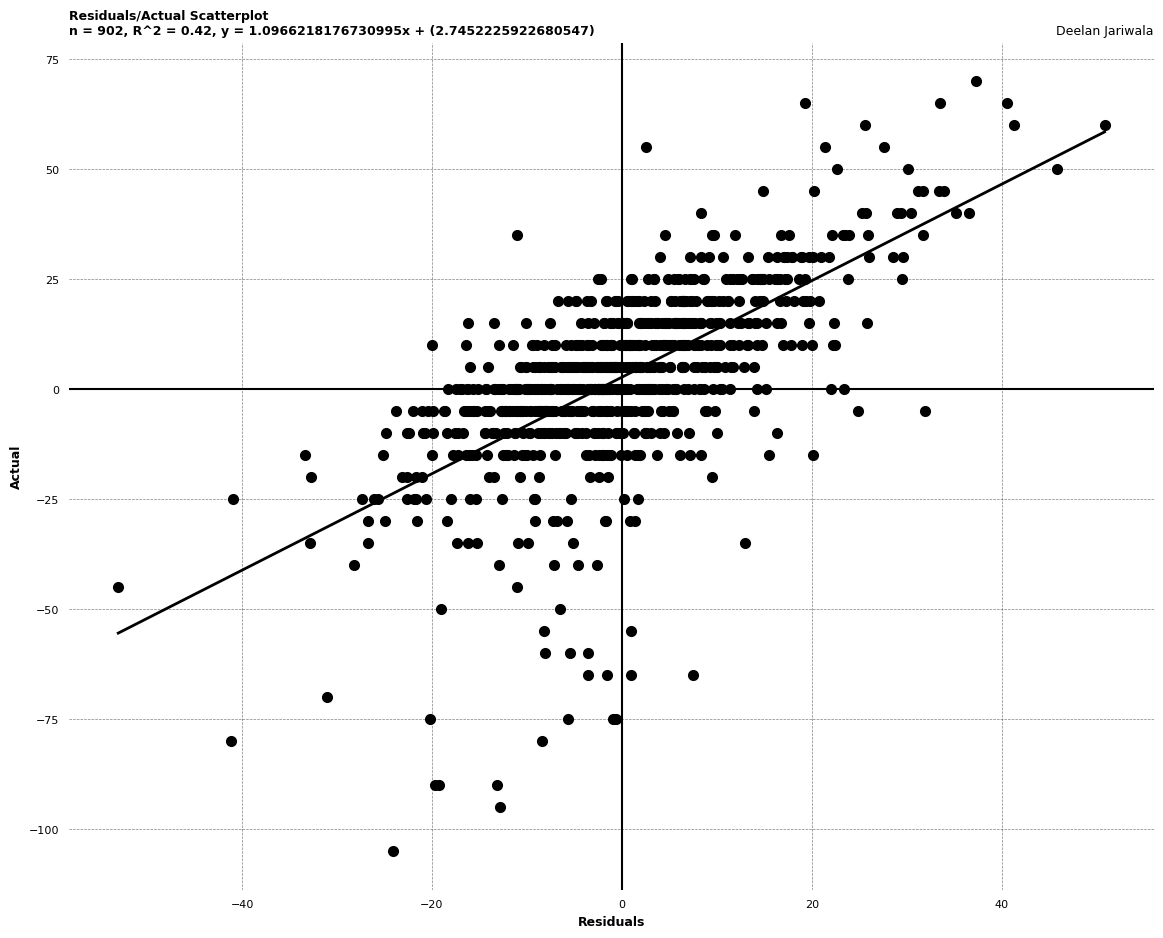

In [ ]:
scatter(['Residuals', testOut - predictTest], ['Actual', testOut])

1171 (1171,)
[[0.0092877]]
-57.825 47.325


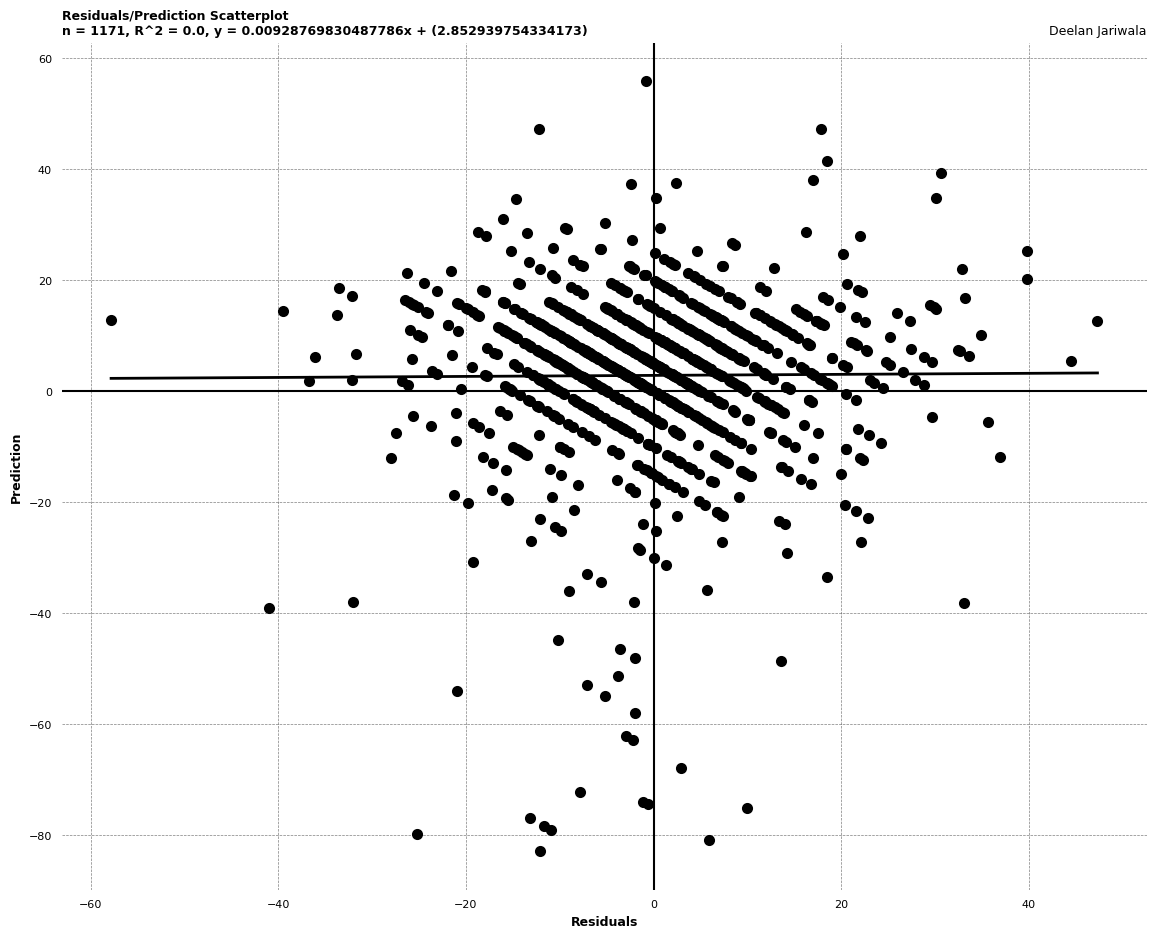

In [ ]:
scatter(['Residuals', testOut - predictTest], ['Prediction', predictTest])

1171 (1171,)
[[-0.01271295]]
-57.825 47.325


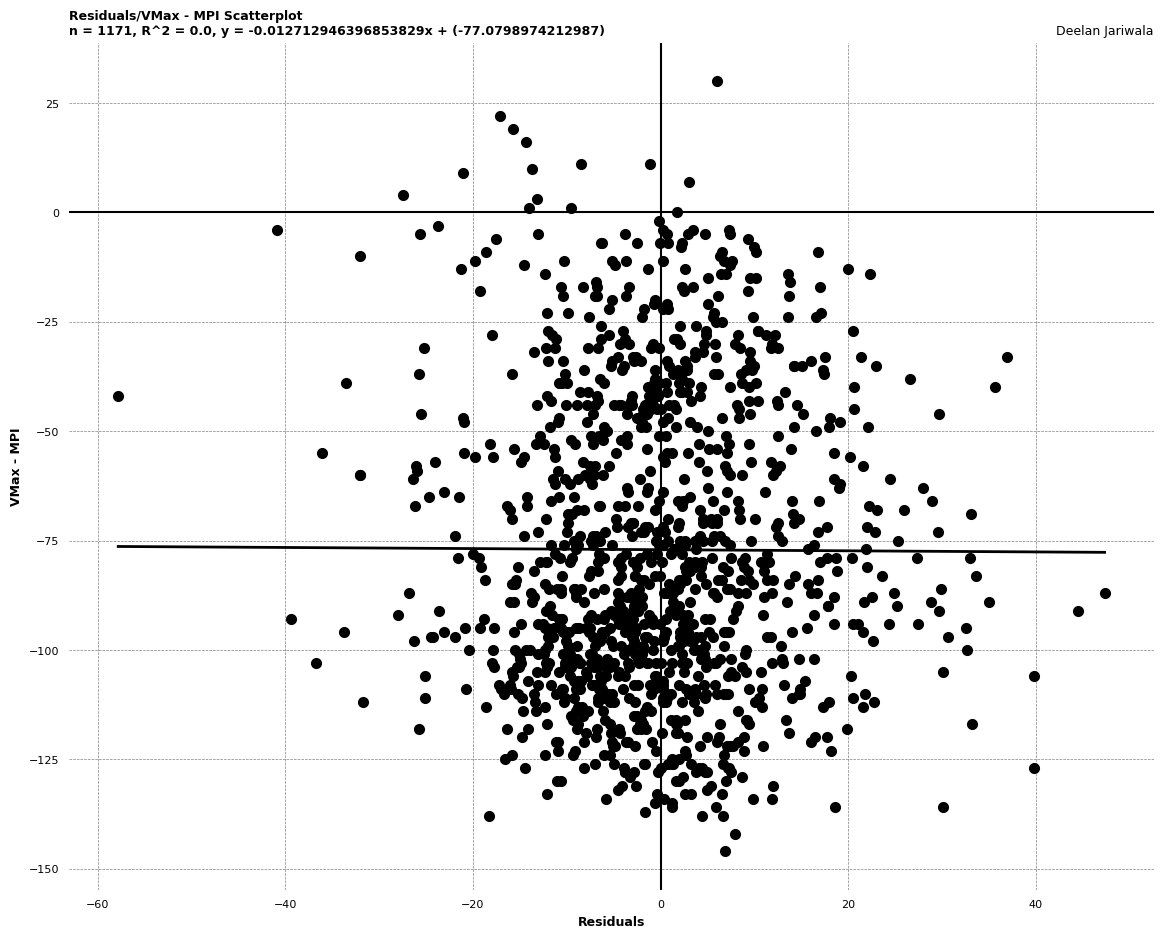

In [ ]:
i = 5
scatter(['Residuals', testOut - predictTest], [xNames[i], testIn[:, i]])

1171 (1171,)
[[1.00591269]]
-82.875 55.85


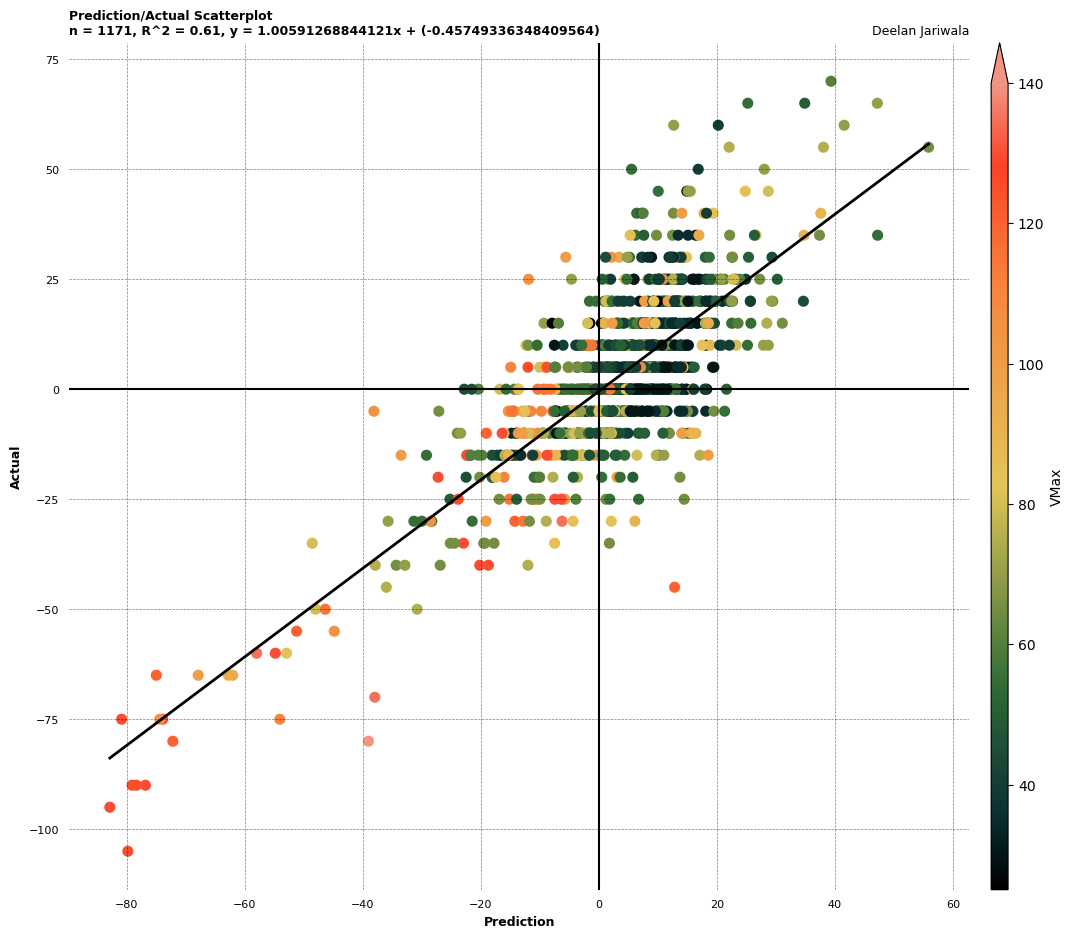

In [ ]:
i = 1
scatter(['Prediction', predictTest], ['Actual', testOut], z = [xNames[i], testIn[:, i]])

Deep-Layer Shear (mag) [ 8.   5.9  5.2 ... 34.6 33.5 26.6]
6671 (6671,)
[[-0.09462724]]
-110.0 95.0


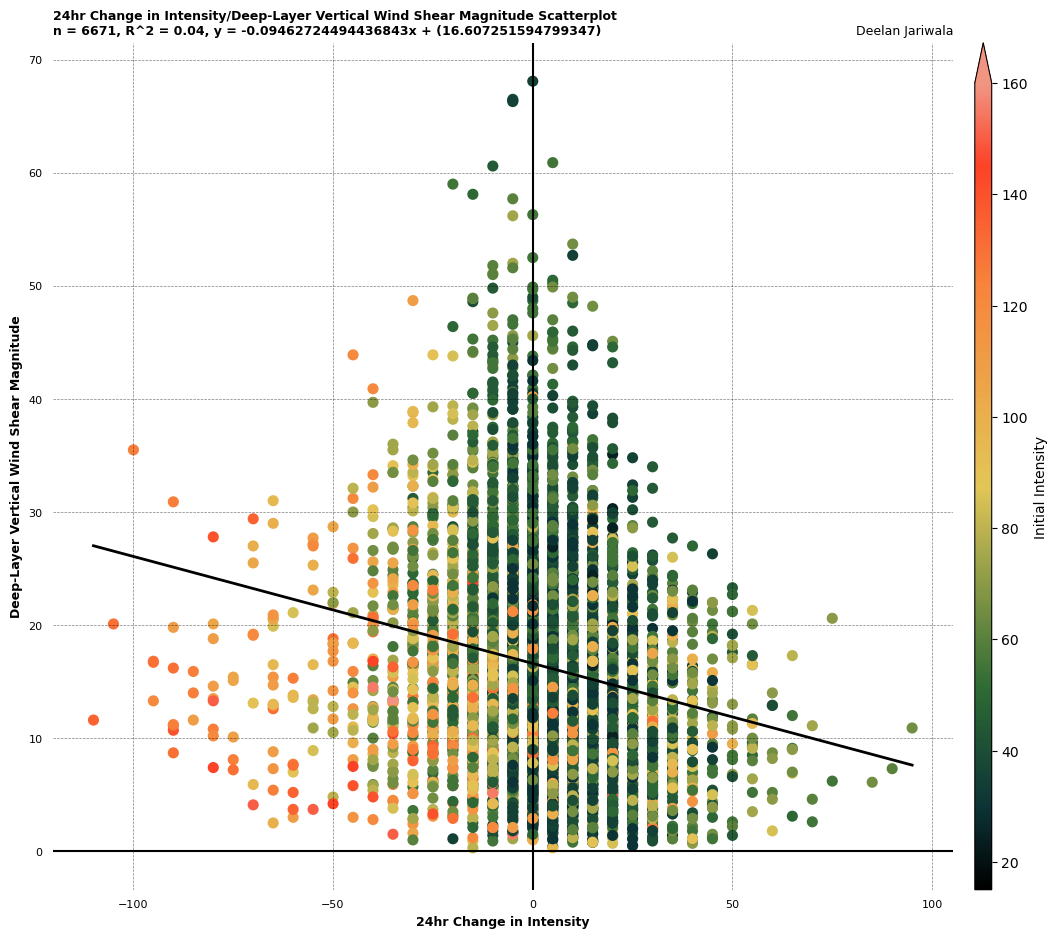

In [ ]:
i = 3
print(xNames[i], testIn[:, i])
scatter(['24hr Change in Intensity', y], ['Deep-Layer Vertical Wind Shear Magnitude', x[:, 3]], z = ['Initial Intensity', x[:, 1]])